In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn import svm

import sklearn.metrics as metrics

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from patsy import dmatrix

pd.options.display.max_columns = 300
pd.options.display.max_rows = 25

# Getting & Selecting Data

In [2]:
df = pd.read_csv('NFL Play by Play 2009-2018.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.to_pickle('nfl_playbyplay.pkl')

In [4]:
nfl_df = pd.read_pickle("nfl_playbyplay.pkl")

In [5]:
nfl_df.play_type.value_counts()

pass           186677
run            132692
no_play         42431
kickoff         25552
punt            23914
extra_point     10934
field_goal       9777
qb_kneel         3830
qb_spike          690
Name: play_type, dtype: int64

In [6]:
# Select only pass and run plays
pass_run_df = df[(nfl_df.play_type == 'pass') | (nfl_df.play_type == 'run')]

In [7]:
pass_run_df.head(5)

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackl

In [8]:
# Selecting my features
columns = ['play_id', 'game_id', 'posteam_type', 'play_type', 'ydstogo', 'down', 'wp', 'yardline_100', 'half_seconds_remaining', 'score_differential', 'posteam_timeouts_remaining', 'interception', 'fumble']

In [9]:
new_pass_run_df = pass_run_df[columns]

In [10]:
new_pass_run_df.replace([np.inf, -np.inf], np.nan, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [11]:
new_pass_run_df.isna().sum()

play_id                         0
game_id                         0
posteam_type                    0
play_type                       0
ydstogo                         0
down                          678
wp                              2
yardline_100                    0
half_seconds_remaining         17
score_differential              0
posteam_timeouts_remaining      0
interception                    0
fumble                          0
dtype: int64

In [12]:
# Remove 2pt conversions
new_pass_run_df = new_pass_run_df[new_pass_run_df['down'].notnull()]

# Drop rows where win percentage is null
new_pass_run_df = new_pass_run_df[new_pass_run_df['wp'].notnull()]

# Zero-fill rows where half_seconds_remaining is null
new_pass_run_df['half_seconds_remaining'].fillna(0, inplace=True)

In [13]:
# Convert target from categorical to numeric (run=1, pass=0)
new_pass_run_df['run_or_pass'] = new_pass_run_df['play_type'].astype("category").cat.codes

# Add numeric column for home/away team (home=1, away=0)
new_pass_run_df['home_away'] = new_pass_run_df['posteam_type'].astype("category").cat.codes

# Feature Engineering

In [14]:
# Yards per play needed for first down
new_pass_run_df['fd_ydsperplay'] = new_pass_run_df['ydstogo'] / (5 - new_pass_run_df['down'])

In [15]:
# Aggregate fumbles and interceptions by game, by team up to current play
fumbles_ints = new_pass_run_df[['play_id','game_id', 'posteam_type', 'interception', 'fumble']]

cumsum_df = fumbles_ints.groupby(['posteam_type', 'game_id']).agg({'interception': ['cumsum'],
                                                                  'fumble': ['cumsum']})
fumbles_ints = fumbles_ints.join(cumsum_df, how='left')

fumbles_ints.drop(columns =["posteam_type", "interception", "fumble"], inplace=True)

new_pass_run_df = pd.merge(new_pass_run_df, fumbles_ints, on=['play_id', 'game_id'], how='left')

new_pass_run_df.drop(columns =["interception", "fumble"], inplace=True)

new_pass_run_df['interception_cum'] = new_pass_run_df['interception', 'cumsum']
new_pass_run_df['fumble_cum'] = new_pass_run_df['fumble', 'cumsum']

new_pass_run_df.drop(columns =[['interception', 'cumsum'], ['fumble', 'cumsum']], inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [16]:
# Create dummies by playtype
dummies = pd.get_dummies(new_pass_run_df['play_type'])
new_pass_run_df = pd.concat([new_pass_run_df, dummies], axis=1)

In [17]:
pr_df = new_pass_run_df[['play_id','game_id', 'posteam_type', 'run', 'pass']]
pr_cumsum_df = pr_df.groupby(['posteam_type', 'game_id']).agg({'run': ['cumsum'],
                                                                  'pass': ['cumsum']})
pr_df = pr_df.join(pr_cumsum_df, how='left')
pr_df.drop(columns =["posteam_type", "pass", "run"], inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [18]:
new_pass_run_df = pd.merge(new_pass_run_df, pr_df, on=['play_id', 'game_id'], how='left')

In [19]:
new_pass_run_df['cum_runs'] = new_pass_run_df['run', 'cumsum']
new_pass_run_df['cum_pass'] = new_pass_run_df['pass', 'cumsum']

new_pass_run_df.drop(columns =[['run', 'cumsum'], ['pass', 'cumsum']], inplace=True)

In [20]:
new_pass_run_df.drop(columns =['run', 'pass'], inplace=True)

In [21]:
new_pass_run_df['cum_pct_run'] = new_pass_run_df['cum_runs']/(new_pass_run_df['cum_runs'] + new_pass_run_df['cum_pass'])

In [22]:
# Drop rows where cum_pct_run is infinite or null
new_pass_run_df = new_pass_run_df.replace([np.inf, -np.inf], np.nan)
new_pass_run_df = new_pass_run_df[new_pass_run_df['cum_pct_run'].notnull()]

In [23]:
new_pass_run_df.describe()

,play_id,game_id,ydstogo,down,wp,yardline_100,half_seconds_remaining,score_differential,posteam_timeouts_remaining,run_or_pass,home_away,fd_ydsperplay,interception_cum,fumble_cum,cum_runs,cum_pass,cum_pct_run
count,343573.000000,3.435730e+05,343573.000000,343573.000000,3.435730e+05,343573.000000,343573.000000,343573.000000,343573.000000,343573.000000,343573.000000,343573.000000,343573.000000,343573.000000,343573.000000,343573.000000,343573.000000
mean,2082.088424,2.013909e+09,8.621385,1.794268,5.017053e-01,52.297090,848.506699,-1.498430,2.549834,0.415356,0.500185,2.799527,0.414439,0.553582,16.902545,22.875051,0.485472
std,1221.651306,2.966666e+06,3.925131,0.819041,2.886686e-01,24.586255,541.543283,11.068071,0.758748,0.492784,0.500001,1.648702,0.717453,0.869674,16.351176,22.243649,1.533905
min,48.000000,2.009091e+09,1.000000,1.000000,2.220446e-16,1.000000,0.000000,-59.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1021.000000,2.011120e+09,6.000000,1.000000,2.756078e-01,34.000000,355.000000,-7.000000,2.000000,0.000000,0.000000,2.333333,0.000000,0.000000,7.000000,9.000000,0.360000
50%,2086.000000,2.014101e+09,10.000000,2.000000,5.116797e-01,56.000000,840.000000,0.000000,3.000000,0.000000,1.000000,2.500000,0.000000,0.000000,14.000000,19.000000,0.428571
75%,3108.000000,2.017010e+09,10.000000,2.000000,7.279894e-01,73.000000,1318.000000,4.000000,3.000000,1.000000,1.000000,3.333333,1.000000,1.000000,21.000000,29.000000,0.500000
max,5637.000000,2.018122e+09,50.000000,4.000000,1.000000e+00,99.000000,1800.000000,59.000000,3.000000,1.000000,1.000000,43.000000,6.000000,8.000000,176.000000,212.000000,155.000000


In [24]:
new_pass_run_df.drop(columns={'play_type', 'posteam_type'}, inplace=True)

# EDA

In [25]:
# Drop play_id and game_id
new_pass_run_df.drop(columns={'play_id', 'game_id'}, inplace=True)

In [26]:
# Assign final model data
model_data = new_pass_run_df.copy()

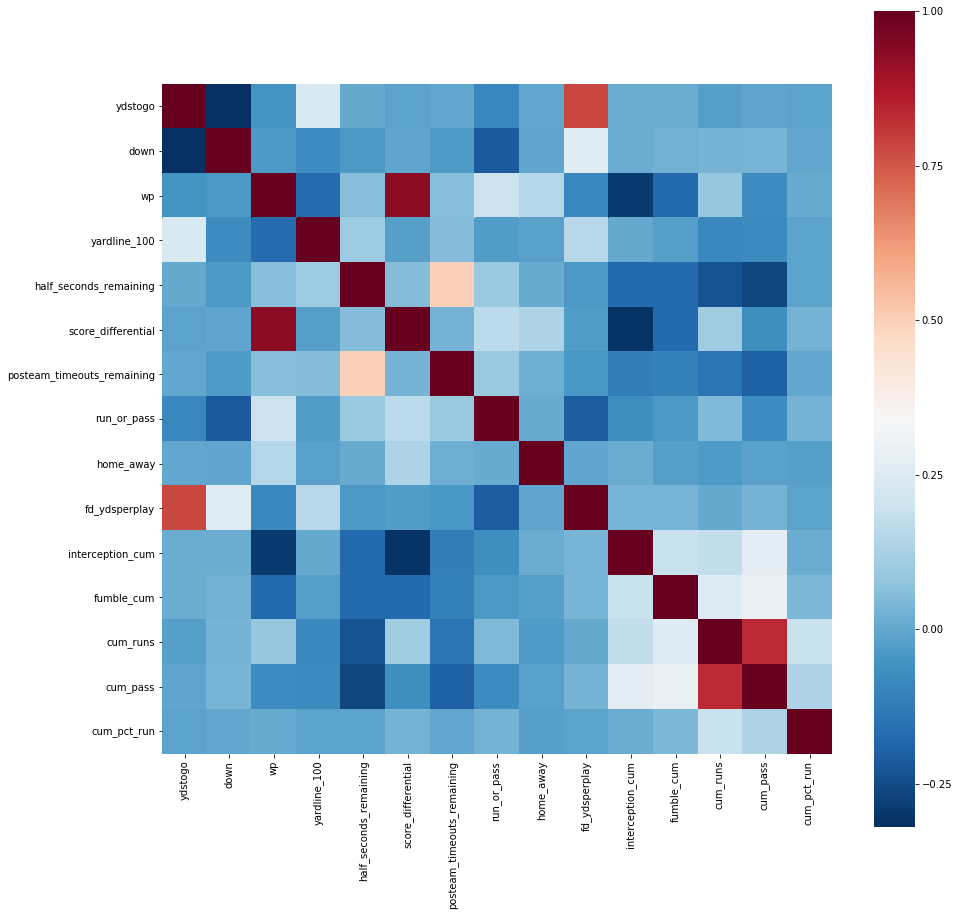

In [27]:
# Plot correlation matrix
corrs = model_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrs, square=True, cmap="RdBu_r");
plt.savefig(fname='corr_matrix', dpi=150)

# Model Setup

In [28]:
model_data.columns

Index(['ydstogo', 'down', 'wp', 'yardline_100', 'half_seconds_remaining',
       'score_differential', 'posteam_timeouts_remaining', 'run_or_pass',
       'home_away', 'fd_ydsperplay', 'interception_cum', 'fumble_cum',
       'cum_runs', 'cum_pass', 'cum_pct_run'],
      dtype='object')

In [29]:
# Setup Patsy dmatrix
x_cols = ['home_away', 'ydstogo', 'down', 'wp', 'yardline_100',
           'half_seconds_remaining', 'score_differential',
           'posteam_timeouts_remaining', 'interception_cum', 'fumble_cum',
           'fd_ydsperplay', 'cum_runs', 'cum_pass', 'cum_pct_run']

x_str = x_cols[0]
for col in x_cols[1:]:
    x_str = x_str + ' + ' + col

x_patsy = dmatrix(x_str, model_data)
x_patsy.shape

(343573, 15)

In [30]:
# Shuffle and split
from sklearn.utils import shuffle

x_raw = x_patsy
y_raw = model_data['run_or_pass']

x_mid, x_test, y_mid, y_test = train_test_split(x_raw, y_raw, \
                                                            test_size=0.2, shuffle=True, stratify=y_raw, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_mid, y_mid, \
                                                            test_size=0.25, shuffle=True, stratify=y_mid, random_state=0)

In [31]:
# Normalize variables
scaler = StandardScaler()
scaler.fit(x_train)
x_norm_train = scaler.transform(x_train)
x_norm_val = scaler.transform(x_val)
x_norm_test = scaler.transform(x_test)

# Modeling 💁

### KNN

In [37]:
ks = [60, 65, 70]
param_grid = dict(n_neighbors=ks)

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(x_norm_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [40, 50, 60]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [87]:
print("Best score: {:6.2f}".format(knn_grid.best_score_))
print("Best parameters: {}".format(knn_grid.best_params_))

Best score:   0.77
Best parameters: {'n_neighbors': 60}


### Logistic Regression

In [49]:
penalty = ['l2']
C = [1000, 100, 50, 10, 1, .1, .001]
param_grid = dict(C=C, penalty=penalty)

In [50]:
logit = LogisticRegression(solver='lbfgs')
logit_grid = GridSearchCV(logit, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
logit_grid.fit(x_norm_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1000, 100, 50, 10, 1, 0.1, 0.001], 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [86]:
print("Best score: {:6.2f}".format(logit_grid.best_score_))
print("Best parameters: {}".format(logit_grid.best_params_))

Best score:   0.74
Best parameters: {'C': 1000, 'penalty': 'l2'}


### Naive Bayes

In [63]:
gnb = GaussianNB()
gnb_best = gnb.fit(x_norm_train, y_train)

In [85]:
print("Best score: {:6.2f}".format(gnb_best.score(x_norm_train, y_train)))

Best score:   0.63


### Random Forest

In [83]:
# GridSearch
# Create the parameter grid
param_grid = {
     'n_estimators': [600, 650, 700],
     'min_samples_split': [3, 5, 7],
     'min_samples_leaf': [1, 2],
     'max_features': ['sqrt'],
     'max_depth': [20, 30, 40],
     'bootstrap': [True]
    }

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
rf_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 127.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 193.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [600, 650, 700], 'min_samples_split': [3, 5, 7], 'min_samples_leaf': [1, 2], 'max_features': ['sqrt'], 'max_depth': [20, 30, 40], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [84]:
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)
print('Best Params for rf: ', rf_grid.best_params_)

Best ROC_AUC for rf: 0.8400
Best Params for rf:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 700}


### SVM

In [90]:
C = [1]
gammas = [0.001, 0.1]
param_grid = dict(C=C, gamma=gammas)

svm1 = svm.SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm1, param_grid, cv=5, verbose=1, scoring='roc_auc', n_jobs=-1)
svm_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 230.4min remaining: 153.6min


KeyboardInterrupt: 

### XGBoost

In [93]:
# RandomSearch

param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]
}

xgb = xgb.XGBClassifier()
rs_xgb = RandomizedSearchCV(xgb, param_grid, n_iter=50,
                            n_jobs=1, verbose=1, cv=5,
                            scoring='roc_auc', refit=True, random_state=41)
rs_xgb.fit(x_norm_train, y_train)

In [99]:
print('Best ROC_AUC for xgb: %0.4f' % rs_xgb.best_score_)
print('Best Params for xgb: ', rs_xgb.best_params_)

Best ROC_AUC for xgb: 0.8346
Best Params for xgb:  {'subsample': 1.0, 'silent': False, 'reg_lambda': 10.0, 'n_estimators': 100, 'min_child_weight': 7.0, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.25, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0}


# ROC Curves

In [101]:
# List of best models
model_list = [knn_grid.best_estimator_,  
              logit_grid.best_estimator_,
              rf_grid.best_estimator_,
              rs_xgb.best_estimator_]
model_name = ['knn', 'logistic', 'random_forest', 'xgboost']

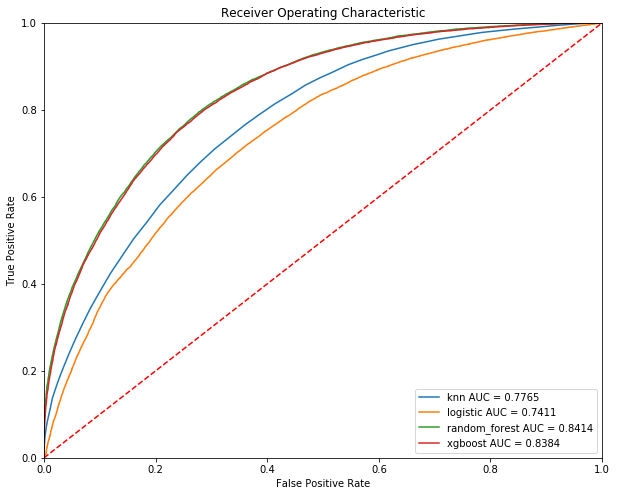

In [104]:
# Plot ROC curve for best models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    y_pred = list(model.predict_proba(x_norm_val)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig(fname='roc_curve', dpi=150)

# Confusion Matrix

In [ ]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(x_test)[:, 1] >= threshold)
    model_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['run', 'pass'],
           yticklabels=['run', 'pass']);
    plt.xlabel('prediction')
x    plt.ylabel('actual')

In [ ]:
make_confusion_matrix(rs_xgb)